<a href="https://colab.research.google.com/github/tsachiblau/sparseGANProject/blob/master/NN_sparse_pursuit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook contains implementation of sparse representation pursuit using NN

Set up & load data set

In [1]:
from keras.optimizers import Adam
import numpy as np
from keras.datasets import mnist

# setting up params
np.random.seed(10)
noise_dim = 100
batch_size = 16
half_batch_size = int(batch_size/2)
steps_per_epoch = 3750  # batch_size * steps_per_epoch = epoch size (train size)
epochs = 5
img_rows, img_cols, channels = 28, 28, 1
sparse_dim = img_rows * img_cols * channels
load_dict = True
# loss functions weight:
L1_weight = 10   # Loss = data_fidelity + L1_weight * L1_norm
thr_value = 0.1
# optimizer - lr & beta are hyper parameters
optimizer = Adam(0.0002,0.5) 
#load data set
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normalize between +1 -1
x_train = x_train.reshape(-1, img_rows*img_cols*channels) # each image as vector
x_test = x_test.reshape(-1, img_rows*img_cols*channels) # each image as vector
np.random.shuffle(x_train)
print(x_train.shape)

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step
(60000, 784)


get dictionary:

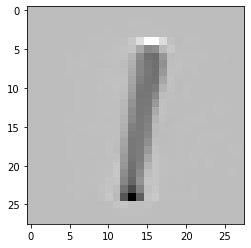

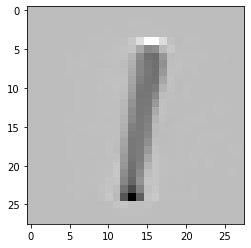

In [3]:
from sklearn.decomposition import DictionaryLearning
from numpy import loadtxt,savetxt
import matplotlib.pyplot as plt
from google.colab import files
from numpy import loadtxt,savetxt
import matplotlib.pyplot as plt

if(load_dict==False):
  # init a dictionary learning alg - based on LARS
  d=DictionaryLearning(n_components=sparse_dim)
  # train dictionary
  d.fit(x_train)
  dictionary = d.components_
  savetxt('dictionary.csv', dictionary, delimiter=',')
  # download to local machine
  files.download('dictionary.csv') 

  # we will download to a local file named dictionary_loaded
  #*reconstruct* an image for sanity check
  representation_vec = d.transform(x_train[1:2,:])
  print(representation_vec.shape)
  print(dictionary_loaded2.shape)
  dictionary_loaded2 = np.transpose(dictionary_loaded2)
  representation_vec = np.transpose(representation_vec)
  ans = np.matmul(dictionary_loaded2,representation_vec)

  plt.figure()
  plt.imshow(ans.reshape((img_rows, img_cols)), cmap='gray')

  plt.figure()
  real_im = x_train[1:2,:]
  plt.imshow(real_im.reshape((img_rows, img_cols)), cmap='gray')
else:
  dictionary_loaded2 = loadtxt('dictionary_loaded.csv', delimiter=',')
  dictionary_loaded2 = np.array(dictionary_loaded2,dtype=np.float32) # format that is used in keras
  # the above dict should enable training a regular gan

  # sanity check
  dictionary_loaded2 = np.transpose(dictionary_loaded2)
  atom1 = (dictionary_loaded2)[:,0]
  plt.figure()
  plt.imshow(atom1.reshape((img_rows, img_cols)), cmap='gray')

  first_atom = np.zeros(784)
  first_atom[0] = 1
  plt.figure()
  ans = np.matmul(dictionary_loaded2,np.transpose(first_atom))
  plt.imshow(ans.reshape((img_rows, img_cols)), cmap='gray')

Creating pursuiter NN

In [0]:
# with pursuit and thresholding approach
# generator:
from keras.utils import plot_model
from keras.models import Sequential
from keras import backend as K
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input
from keras.models import Model
from keras.initializers import RandomNormal, glorot_uniform
from keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout, AveragePooling2D, MaxPooling2D, BatchNormalization, Lambda, ReLU, ThresholdedReLU, Activation
from tensorflow.linalg import matmul, matrix_transpose
from tensorflow.math import abs
from keras import regularizers


from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from tensorflow import cast

# would cause small entries in absulute values to be set to zero and will create sparse vectors
def soft_threshlding(x):
  above_thr_pos = x * cast(x >= thr_value, tf.float32)
  below_thr_neg = x * cast(x <= -thr_value, tf.float32)
  return (above_thr_pos + below_thr_neg)

get_custom_objects().update({'soft_threshlding': Activation(soft_threshlding)})

def create_pursuiter():
    pursuiter = Sequential()
    init = RandomNormal(0,stddev=0.02)
    pursuiter.add(Dense(1024, kernel_initializer=init, input_dim=784,name="pursuiter_input"))
    pursuiter.add(BatchNormalization())
    pursuiter.add(LeakyReLU(0.2))

    pursuiter.add(Dense(1024,kernel_initializer=init,name="pursuiter_2nd"))
    pursuiter.add(BatchNormalization())
    pursuiter.add(LeakyReLU(0.2))

    pursuiter.add(Dense(sparse_dim, kernel_initializer=init,name="pursuiter_3rd"))
    pursuiter.add(BatchNormalization())
    # soft thresholding activation
    pursuiter.add(Activation(soft_threshlding, name='soft_threshlding'))

    #pursuiter.add(Lambda(lambda x: matrix_transpose(matmul(dictionary_loaded2,matrix_transpose(x))),name='mul_in_D'))

    #pursuiter.compile(loss='mean_squared_error', optimizer=optimizer)
    return pursuiter

pursuiter = create_pursuiter()
pursuiter.name = "pursuit_unit"
pursuiter_input = Input(shape=(784,))

sparse_vec = pursuiter(pursuiter_input) 

# a layer that creates the multiplication between the sparse tensor with dictionary to create image
fake_image_vec = Lambda(lambda x: matrix_transpose(matmul(dictionary_loaded2,matrix_transpose(x))),name='mul_in_D')(sparse_vec)


pursuiter_full = Model(pursuiter_input, [fake_image_vec,sparse_vec])
pursuiter_full.compile(loss=['mean_squared_error','mean_absolute_error'], optimizer=optimizer,loss_weights=[1,L1_weight])
pursuiter_full.name = "pursuiter_full"
print(pursuiter_full.summary())

#train
zeros = np.zeros(10000*784)
zeros=zeros.reshape(10000,784)
model1=pursuiter_full.fit(x_train, [x_train,x_train], validation_data=(x_test, [x_test,zeros]), epochs=epochs, batch_size=16)

plot_model(pursuiter_full, to_file='model_plot.png', show_shapes=True, show_layer_names=True,expand_nested=True)


plt.figure()
print(model1.history)
plt.plot(range(1,len(model1.history['loss'])+1),model1.history['loss'], label='Train Acc')
plt.plot(range(1,len(model1.history['val_loss'])+1),model1.history['val_loss'], label='Test Acc')
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.grid()
plt.show()






Model: "pursuiter_full"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
pursuit_unit (Sequential)    (None, 784)               2668368   
_________________________________________________________________
mul_in_D (Lambda)            (None, 784)               0         
Total params: 2,668,368
Trainable params: 2,662,704
Non-trainable params: 5,664
_________________________________________________________________
None



Train on 60000 samples, validate on 10000 samples
Epoch 1/5





21904/60000 [=========>....................] - ETA: 1:38 - loss: 8.2078 - mul_in_D_loss: 0.2937 - pursuit_unit_loss: 0.7914

analyse results:

In [0]:
import random

x_train_pred = pursuiter.predict(x_train)
print("average support on train= ", np.count_nonzero(x_train_pred)/60000)

x_test_pred = pursuiter.predict(x_test)
print("average support on test= ", np.count_nonzero(x_test_pred)/10000)

im = random.randrange(0, 9999)
x_train.shape
x = np.array([x_test[im,:]])

# plt results
print("Im_r, Im")
plt.figure()
plt.imshow(pursuiter_full.predict(x)[0].reshape((img_rows, img_cols)), cmap='gray')

plt.figure()
plt.imshow(x[0].reshape((img_rows, img_cols)), cmap='gray')

# is it sparse?
pred = pursuiter.predict(x)
print("sparse vector dim = ", pred.shape)
print("sparse vector non zeros = ", np.count_nonzero(pred))
print("sparse vec max element is = ",np.max(pred))
print("positive number = ", np.count_nonzero(pred[pred>0]))
print("sparse vec average positive =",np.mean(pred[pred>0]))
print("negatives number = ", np.count_nonzero(pred[pred<0]))
print("sparse vec average negative =",np.mean(pred[pred<0]))